In [1]:
import os
import random
import tarfile
import sys
import cv2
import time
import tensorflow as tf
from IPython.display import clear_output
from scipy import ndimage
import numpy as np
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline

url = 'http://commondatastorage.googleapis.com/books1000/'

def download(filename):
    destination_file = "data/" + filename
    if not os.path.exists(destination_file):
        print("Dowloading ", filename, "into ", destination_file)
        urlretrieve(url + filename, destination_file)
    else:
        print "File already exists: %s" %filename
    return destination_file

def untar(filename):
    folder = filename.split(".tar")[0]
    if os.path.isdir(folder):
        print("%s already extracted" %filename)
    else:
        print("Extracting %s, please wait" %filename)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall("data")
        tar.close()
    extracted_folders = [
        os.path.join(folder, subfolder) for subfolder in sorted(os.listdir(folder))
        if os.path.isdir(os.path.join(folder, subfolder))]
    print(extracted_folders)
    return extracted_folders

def plt_imshow(image):
    plt.imshow(image, cmap = 'gray');
    plt.axis('off')
    plt.show()

<img src="https://upload.wikimedia.org/wikipedia/en/7/74/TensorFlow.png" width='300' align='right'/>

## TensorFlow - Deep Learning
Open source software library for numerical computation using data flow graphs. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them.

## What is a data flow graph?
<img src="https://software.intel.com/sites/default/files/did_feeds_images/04bf8e3d-e689-47df-86e3-65027c891574/04bf8e3d-e689-47df-86e3-65027c891574-imageId=39b547c9-4958-4d00-8672-8331ce994264.jpg" align='right' width='500px'/>
Data (Edges):
- Bread
- Peanut Butter
- Jelly

Transformations (Nodes):
- Get
- Put

<img src="https://www.tensorflow.org/images/tensors_flowing.gif" align='right' width='400px'/>

## TensorFlow definition
Data flow graphs describe mathematical computation with a directed graph of nodes & edges. Nodes typically implement mathematical operations, but can also represent endpoints to feed in data, push out results, or read/write persistent variables. Edges describe the input/output relationships between nodes. These data edges carry dynamically-sized multidimensional data arrays, or tensors. The flow of tensors through the graph is where TensorFlow gets its name. Nodes are assigned to computational devices and execute asynchronously and in parallel once all the tensors on their incoming edges becomes available.

![](images/udacity.png)

Dataset and images in this notebook are from taken from the Udacity course.

## Data images to use
The notMNIST database of handwritten digits. Has a set of 200,000 examples, and a set of 10,000 examples.

<img src="images/1.png" align="left" width='210px'/>
<img src="images/2.png" align="left" width='210px'/>
<img src="images/3.png" align="left" width='210px'/>
<img src="images/4.png" align="left" width='210px'/>
<img src="images/5.png" align="left" width='210px'/>
<img src="images/6.png" align="left" width='210px'/>
<img src="images/7.png" align="left" width='210px'/>
<img src="images/8.png" align="left" width='210px'/>
<img src="images/9.png" align="left" width='210px'/>
<img src="images/10.png" align="left" width='210px'/>

We will use the small dataset of 10,000 examples

## Downloading Data

In [2]:
if not os.path.exists('data/pictures_tf'):
    os.makedirs('data/pictures_tf')

data_filename = download('notMNIST_small.tar.gz')
print '\nData folders:'
data_folders = untar(data_filename)

('Dowloading ', 'notMNIST_small.tar.gz', 'into ', 'data/notMNIST_small.tar.gz')

Data folders:
Extracting data/notMNIST_small.tar.gz, please wait
['data/notMNIST_small/A', 'data/notMNIST_small/B', 'data/notMNIST_small/C', 'data/notMNIST_small/D', 'data/notMNIST_small/E', 'data/notMNIST_small/F', 'data/notMNIST_small/G', 'data/notMNIST_small/H', 'data/notMNIST_small/I', 'data/notMNIST_small/J']


## Reviewing the Data

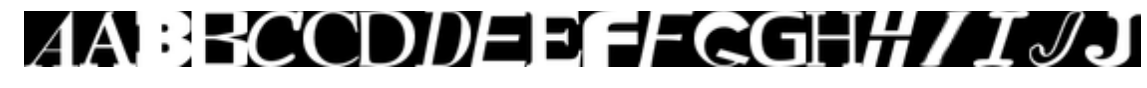

Maximum pixel intensity value: 255.00
Shape of images (28, 28)


In [3]:
# display a two random image from each letter in the train folder
def print_images(folders):
    images = []
    for folder in folders:
        images_path = os.listdir(folder)
        for i in range(2):
            image_path = os.path.join(folder,
                                      random.choice(images_path))
            images.append(ndimage.imread(image_path))
#             images.append(plt.imread(image_path))
#             images.append(cv2.imread(image_path), 0)
    plt.figure(figsize=(20, 1))
    plt_imshow(np.hstack(images))
    print 'Maximum pixel intensity value: %.2f' %np.amax(images[0])
    print 'Shape of images ' + str(images[0].shape) 

print_images(data_folders)

## Deep Learning Concepts

- Logistic Regression
    - Inputs, weights, biases, logits
    - Softmax Function
- Stochastic Gradient Descent
    - Exponential Decaying Learning Rate
- Neural Networks
    - Relu Layer
    - L2 regularization
    - Dropout
- Convolutional Neural Networks
    - Patch
    - Max Pooling

### Logistic Regression
#### Inputs * Weights + Biases = Logits
![](images/deep_learning/1.png)

### Logistic Regression
#### Softmax Function
![](images/deep_learning/2.png)

### Logistic Regression Overview
![](images/deep_learning/3.png)

### Stochastic Gradient Descent
![](images/deep_learning/9.png)

### Stochastic Gradient Descent
#### Learning Rate
![](images/deep_learning/10.png)

![](images/deep_learning/4.png)

## Neural Networks
### Relu
![](images/deep_learning/5.png)

### Logistic Regression --> Relu --> Logistic Regression
![](images/deep_learning/6.png)

### Neural Networks
![](images/deep_learning/7.png)

### Neural Networks
#### Drop Out
![](images/deep_learning/8.png)

### Convolutional Neural Networks
![](images/deep_learning/11.png)


### Images: Convolutional Neural Networks
### Text: Embeddings and Recurrent Neural Networks
![](images/deep_learning/12.png)

### Convolutional Neural Networks
#### Patch
![](images/deep_learning/13.png)

### Convolutional Neural Networks
#### Max Pooling
![](images/deep_learning/14.png)

### Convolutional Neural Networks
![](images/deep_learning/15.png)

## Building the Dataset

In [4]:
img_size = 28 # pixel size
num_imgs = 1500 # images per class
num_classes = 10

def build_dataset(folders):
    dataset = np.ndarray((num_imgs * num_classes, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(num_imgs * num_classes, dtype=np.int32)
    counter = 0
    for img_class, folder in enumerate(folders):
        per_class_counter = 0
        for img_name in os.listdir(folder):
            if per_class_counter < num_imgs:
                img_path = os.path.join(folder, img_name)
                try:
                    img = ndimage.imread(img_path).astype(float) # Convert to float
                    img = (img - 255 / 2) / 255 # Normalization
                    if img.shape == (img_size, img_size):
                        dataset[counter] = img
                        labels[counter] = img_class
                        counter += 1
                        per_class_counter += 1
                    else:
                        raise Exception("Unexpected image shape")
                except Exception as e:
                    print 'Unable to use image: ' + str(e)
    return dataset, labels

In [5]:
dataset, labels = build_dataset(data_folders)
print '\nTotal number of images: %d' %dataset.shape[0]
print 'Images Shape:' + str(dataset[0].shape)
print 'Dataset Shape: ' + str(dataset.shape)

Unable to use image: cannot identify image file 'data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png'
Unable to use image: cannot identify image file 'data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png'

Total number of images: 15000
Images Shape:(28, 28)
Dataset Shape: (15000, 28, 28)


## Train, Validation and Test Sets

In [6]:
train_size = 1000
valid_size = 250
test_size = 250

train_ds = np.ndarray((train_size * num_classes, img_size, img_size),dtype=np.float32)
train_lb = np.ndarray(train_size * num_classes, dtype=np.int32)

valid_ds = np.ndarray((valid_size * num_classes, img_size, img_size), dtype=np.float32)
valid_lb = np.ndarray(valid_size * num_classes, dtype=np.int32)

test_ds = np.ndarray((test_size * num_classes, img_size, img_size), dtype=np.float32)
test_lb = np.ndarray(test_size * num_classes, dtype=np.int32)

In [7]:
for i in range(10):
    start_set, end_set = i * num_imgs, (i + 1) * num_imgs
    start_train, end_train = i * train_size, (i + 1) * train_size
    start_valid, end_valid = i * valid_size, (i + 1) * valid_size
    start_test, end_test = i * test_size, (i + 1) * test_size
    
    letter_set = dataset[start_set : end_set]
    np.random.shuffle(letter_set)
    
    train_ds[start_train : end_train] = letter_set[0: train_size]
    train_lb[start_train : end_train] = i
    valid_ds[start_valid : end_valid] = letter_set[train_size: train_size + valid_size]
    valid_lb[start_valid : end_valid] = i
    test_ds[start_test : end_test] = letter_set[train_size + valid_size: train_size + valid_size + test_size]
    test_lb[start_test : end_test] = i

print("Train Shapes --> Dataset: %s   Labels: %s" %(train_ds.shape, train_lb.shape))
print("Valid Shapes --> Dataset: %s    Labels: %s" %(valid_ds.shape, valid_lb.shape))
print("Test Shapes  --> Dataset: %s    Labels: %s" %(test_ds.shape, test_lb.shape))

Train Shapes --> Dataset: (10000, 28, 28)   Labels: (10000,)
Valid Shapes --> Dataset: (2500, 28, 28)    Labels: (2500,)
Test Shapes  --> Dataset: (2500, 28, 28)    Labels: (2500,)


## Visualize Datasets

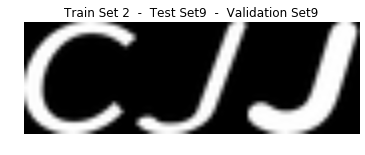

In [8]:
for i in np.random.randint(0, 2500, 10):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_ds[i], test_ds[i], valid_ds[i])), cmap = 'gray')
    plt.title("Train Set " + str(train_lb[i]) +  
              "  -  Test Set" + str(test_lb[i]) + 
              "  -  Validation Set" + str(valid_lb[i])) 
    plt.axis('off')
    plt.show()
    time.sleep(1)

## Randomize Dataset

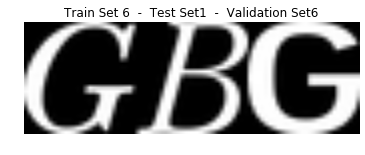

In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_ds = dataset[permutation]
    shuffled_lb = labels[permutation]
    return shuffled_ds, shuffled_lb

train_ds, train_lb = randomize(train_ds, train_lb)
test_ds, test_lb = randomize(test_ds, test_lb)
valid_ds, valid_lb = randomize(valid_ds, valid_lb)

for i in np.random.randint(0, 2500, 5):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_ds[i], test_ds[i], valid_ds[i])), cmap = 'gray')
    plt.title("Train Set " + str(train_lb[i]) + 
              "  -  Test Set" + str(test_lb[i]) + 
              "  -  Validation Set" + str(valid_lb[i]))
    plt.axis('off')
    plt.show()
    time.sleep(1)

## Reformat Input Shape

In [10]:
num_channels = 1 # grayscale

def reformat(dataset, labels):
    # as.type is not needed as the array is already float32 but just in case
    dataset = dataset.reshape((-1, img_size, img_size, num_channels)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_classes) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_ds, train_lb = reformat(train_ds, train_lb)
valid_ds, valid_lb = reformat(valid_ds, valid_lb)
test_ds, test_lb = reformat(test_ds, test_lb)

print("Train Shapes --> Dataset: %s   Labels: %s" %(train_ds.shape, train_lb.shape))
print("Valid Shapes --> Dataset: %s    Labels: %s" %(valid_ds.shape, valid_lb.shape))
print("Test Shapes  --> Dataset: %s    Labels: %s" %(test_ds.shape, test_lb.shape))

Train Shapes --> Dataset: (10000, 28, 28, 1)   Labels: (10000, 10)
Valid Shapes --> Dataset: (2500, 28, 28, 1)    Labels: (2500, 10)
Test Shapes  --> Dataset: (2500, 28, 28, 1)    Labels: (2500, 10)


## Accuracy

In [11]:
def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

## Deep Learning Model
This is a very simple deep learning model, please make it better by:
- Adding Convolutional Layer
- Adding learning exponential decay
- Adding a hidden layer
- Adding a 2nd convolutional layer
- Reducing the patch stride and applying Max Pool
- Adding dropout
- Playing with parameters

In [12]:
batch_size = 50
patch_size = 5
depth1 = 2
# depth2 = 16
# num_hidden = 4

graph = tf.Graph()

with graph.as_default():
    
    #Input data
    tf_train_ds = tf.placeholder(tf.float32, shape=(batch_size, img_size, img_size, num_channels))
    tf_train_lb = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
    tf_valid_ds = tf.constant(valid_ds)
    tf_test_ds = tf.constant(test_ds)
    
    # Variables.
#     patch1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
#     patch1_biases = tf.Variable(tf.zeros([depth1]))
    
#     patch2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
#     patch2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
    # divided by four because that is the size once the patches have scanned the image
#     layer1_weights = tf.Variable(tf.truncated_normal(
#                                  [img_size // 4 * img_size // 4 * depth1, num_classes], stddev=0.1))
    layer1_weights = tf.Variable(tf.truncated_normal(
                                 [img_size * img_size * num_channels, num_classes], stddev=0.1))
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[num_classes]))
    
    
#     layer2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_classes], stddev=0.1))
#     layer2_biases = tf.Variable(tf.constant(1.0, shape=[num_classes]))
    
    # Model
    def model(data, training):
        # first convolution layer. Stride only matter in two elements in the middle
#         conv = tf.nn.conv2d(data, patch1_weights, [1, 4, 4, 1], padding="SAME")
#         conv = tf.nn.max_pool(conv1 + patch1_biases, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME" )
#         conv = tf.nn.relu(conv)
        
        # second convolution layer
#         conv = tf.nn.conv2d(conv, patch2_weights, [1, 2, 2, 1], padding="SAME")
#         conv = tf.nn.max_pool(conv + patch2_biases, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME" )
#         conv = tf.nn.relu(conv)

        # reshape to apply fully connected layer
#         shape_conv = conv.get_shape().as_list()
#         input_hidden = tf.reshape(conv, [shape_conv[0], shape_conv[1] * shape_conv[2] * shape_conv[3]])
        input_hidden = tf.reshape(data, [-1, img_size * img_size * num_channels])
#         hidden_layer = tf.nn.relu(tf.matmul(input_hidden, layer1_weights) + layer1_biases)
        
        # adding dropout layer
#         if training:
#             hidden_layer = tf.nn.dropout(hidden_layer, 0.6)
        
        return tf.matmul(input_hidden, layer1_weights) + layer1_biases
#         return tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    
    # training computation
    logits = model(tf_train_ds, True)
    regularization = 0 #tf.nn.l2_loss(layer1_weights) #+ tf.nn.l2_loss(layer2_weights)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_lb)) + \
           .0005 * regularization
    
    # Optimizer
    global_step = tf.Variable(0)
#     learning_rate = tf.train.exponential_decay(0.05, global_step, 200, 0.95, staircase = True)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.05).minimize(loss, global_step=global_step)


    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_ds, False))
    test_prediction = tf.nn.softmax(model(tf_test_ds, False))

## Execute Graph

In [13]:
num_steps = 201

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # randomize offset
        offset = (step * batch_size) % (train_lb.shape[0] - batch_size)
        batch_ds = train_ds[offset:(offset + batch_size)]
        batch_lb = train_lb[offset:(offset + batch_size)]
        
        feed_dict = {tf_train_ds : batch_ds, tf_train_lb : batch_lb}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_lb))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_lb))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_lb))

Initialized
Minibatch loss at step 0: 3.170311
Minibatch accuracy: 10.0%
Validation accuracy: 7.9%
Test accuracy: 87.2%
